
## Régression logistique

_Fichier à modifier_ : [`logistic_regression.ipynb`](./logistic_regression.ipynb)

La régression logistique fonctionne un peu comme la régression linéaire, cependant c'est un problème de classification (ici binaire).

## Implémentation

1. Créer les données :
   1. Générer un jeu de données `S` de couples $(x, y)$ où $x \in \mathbb{R}^2$ et $y = \mathbf{1}_{w x + b > 0}$. Garder les paramètres $\theta := (w, b)$ pour la suite.
   2. Visualiser les données et la frontière $w x + b = 0$.
   3. Séparer les données en deux datasets : un jeu d'entraînement (`S_train`, 80 %) et un jeu de validation (`S_test`, 20 %).
2. Entraîner un modèle $\theta_0$ de régression logistique (`nn.Linear` + `nn.Sigmoid`) avec la perte _binary cross-entropy_ (`torch.nn.BCELoss`) et la descente de gradient stochastique (`torch.optim.SGD`).
3. Créer un nouveau jeu de données corrompu `S_corr` à partir `S` en appliquant du _label flipping_ à une fraction $\alpha \in [0, 1]$ des données $(x, y)$ : pour cette partie, on remplace le label $y$ par son opposé, $1 - y$.
4. Visualiser les données corrompues.
5. Créer un nouveau modèle  $\theta_1$ et l'entraîner sur ce nouveau jeu de données corrompu. Afficher la précision de $\theta_1$ sur `S_test`.
6. Dans les sous-questions suivantes, on va créer de **nouveaux** modèles avec des paramètres différents (écrire une fonction pour éviter de répéter le code de la question précédente). Afficher les différentes courbes de précision lorsque l'on fait varier un paramètre.
   1. Faire varier la valeur de $\alpha$.
   2. Créer un nouveau jeu de données de sorte que les valeurs de $x$ ne sont pas réparties uniformément, et refaire l'expérience. Par exemple, on concentre les valeurs de $x$ autour de $1$ ou plusieurs clusters (avec un mélange gaussien par exemple). Faire en sorte qu'au moins un des clusters soit proche de la frontière de classification. Que se passe-t-il ? On utilisera ce nouveau jeu de données dans la suite.
   3. Que se passe-t-il si l'on applique le _label flipping_ spécifiquement sur les points $x$ très proches de la frontière ?
   4. Faire varier la dimension de `x`.
7. _Bonus_ : que se passe-t-il si l'on rajoute des couches (_hidden layers_) ?
8. _Bonus_ : que se passe-t-il avec peu de données ?
9.  _Bonus_ : que se passe-t-il si au lieu de créer un nouveau modèle $\theta_1$, on continue l'entraînement du modèle $\theta$ sur `S_corr` ?

## Analyse
   1. Faire le lien avec les chapitres sur la classification dans le cours de Statistiques.
   2. Expliquer brièvement le concept du mélange gaussien.
   3. Établir une relation empirique entre l'imprécision du modèle et la proportion de points "proches" de la frontière.
   4. Faire le lien avec le concept du jailbreaking. Pour illustration, voir la slide 26 : _Évasion (jailbreaking)_ de la [conférence de Lê Nguyên Hoang en décembre 2024](https://science4all.org/wp-content/uploads/2024/12/piaf.pdf)
   5. Établir une relation empirique entre l'imprécision du modèle et la dimension de `x`.
   6. Peut-on imaginer un moyen d'identifier l'empoisonnement, de filtrer les données suspicieuses ou d'agréger les gradients d'un mini-batch de manière robuste ? Exemple d'approche sur [Scikit-Learn](https://scikit-learn-extra.readthedocs.io/en/stable/modules/robust.html)

In [332]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import numpy as np


### Résultats déterministes

In [333]:
import random
seed = 0x2023_2024
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
np.random.seed(seed)
random.seed(seed)

## Générer des données aléatoires

On génère 1000 couples de points $X=(x1,x2)$ selon une distribution normale standard. Ensuite, on trace une droite (déterminée par les float $W$ et $b$ à l'aide de l'équation $y=Wx+b$). Cette droite permet d'atribbuer un label à chaque point : 1 si le point est au dessus de la droite et 0 sinon.

In [334]:
X = torch.randn((1000, 2))
X1 = X[:, 0]
X2 = X[:, 1]
W = torch.randn(1)

b = torch.randn(1)

Z = W * X1 + b
y = (X2 > Z).int().float()

S = TensorDataset(X,y)

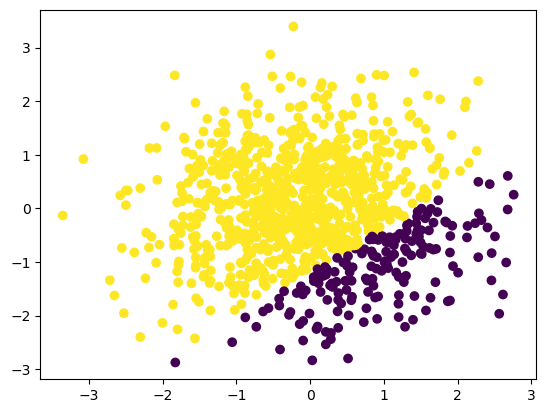

In [335]:
plt.scatter(X1, X2, c=y)


### Séparation du jeu de données (entraînement / validation)

In [336]:
N = len(S)

In [339]:
batch_size = 16

def train_test_split(S):
    # Calculer les tailles exactes
    dataset_size = len(S)
    train_size = int(0.8 * dataset_size)
    test_size = dataset_size - train_size
    
    # Diviser le dataset
    S_train, S_test = random_split(S, [train_size, test_size])
    
    # Créer les DataLoaders
    train_loader = DataLoader(S_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(S_test, batch_size=batch_size)
    
    return train_loader, val_loader

### Définition du Modèle

In [343]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Couche linéaire

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Sigmoïde pour la probabilité
    
model = LogisticRegressionModel(input_dim=2)  # 2 caractéristiques

In [344]:
def make_optimizer(model):
    # Descente de gradient
    return optim.SGD(model.parameters(), lr=0.01)

In [345]:
# 3. Définir la fonction de perte et l'optimiseur
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

# ATTENTION : il faut absolument recréer l'optimizer
# à chaque fois qu'on ré-entraîne un nouveau modèle
optimizer = make_optimizer(model)

### Entraînement

In [346]:
def train_model(model, train_loader, val_loader, verbose=False):
    # ATTENTION : l'optimiseur doit toujours être recréé
    optimizer = make_optimizer(model)
    
    epochs = 100
    for epoch in range(epochs):
        model.train()  # Mode entraînement
        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
        
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        # Validation
        if (epoch + 1) % 10 == 0:
            model.eval()  # Mode évaluation
            val_loss = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs).squeeze()
                    val_loss += criterion(outputs, labels).item()
        
            if verbose:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss / len(val_loader):.4f}")


In [347]:
train_loader, val_loader = train_test_split(S)
train_model(model, train_loader, val_loader, verbose=True)

model.eval()
# S.tensors[0] ?



Epoch 10/100, Loss: 0.4172, Val Loss: 0.4145
Epoch 20/100, Loss: 0.3054, Val Loss: 0.2931
Epoch 30/100, Loss: 0.1910, Val Loss: 0.2450
Epoch 40/100, Loss: 0.2292, Val Loss: 0.2177
Epoch 50/100, Loss: 0.1542, Val Loss: 0.1996
Epoch 60/100, Loss: 0.1407, Val Loss: 0.1864
Epoch 70/100, Loss: 0.1771, Val Loss: 0.1761
Epoch 80/100, Loss: 0.1548, Val Loss: 0.1679
Epoch 90/100, Loss: 0.1881, Val Loss: 0.1610
Epoch 100/100, Loss: 0.1323, Val Loss: 0.1552


LogisticRegressionModel(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

### Frontière du nuage de points :

[-3.35554743 -2.67609554 -1.99664365 -1.31719176 -0.63773987  0.04171202
  0.72116391  1.4006158   2.08006769  2.75951958]


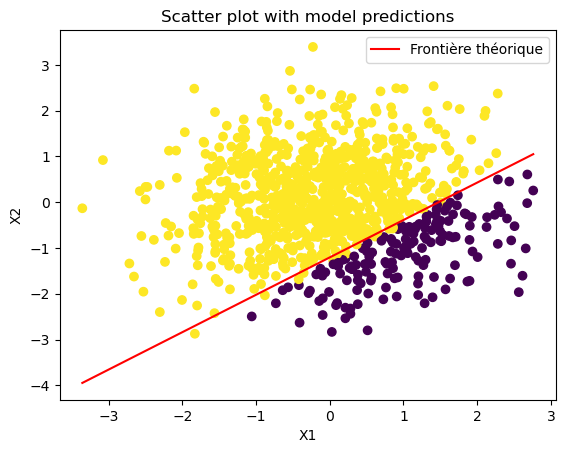

In [349]:
inputs = S[:][0] 

# Calculer les prédictions du modèle
predictions = model(inputs).detach().numpy() 

# Créer le nuage de points
plt.scatter(X1, X2, c=(predictions>0.5))
plt.xlabel('X1')
plt.ylabel('X2')

#Tracer la frontière théorique
x_th=np.linspace(min(X1),max(X1),10)
print(x_th)
plt.plot(x_th,W*x_th+b,c="red",label="Frontière théorique")
plt.title('Scatter plot with model predictions')
plt.legend()
plt.show()

### Jeu de données Corrompu

In [236]:
def make_corrupted_dataset(alpha):
    # Calculer combien de labels inverser
    num_labels_to_flip = int(alpha * N)

    # Sélectionner aléatoirement les indices à inverser
    flip_indices = np.random.choice(N, num_labels_to_flip, replace=False)

    Y_corr = y.clone()
    Y_corr[flip_indices] = 1 - Y_corr[flip_indices]

    return TensorDataset(X, Y_corr)

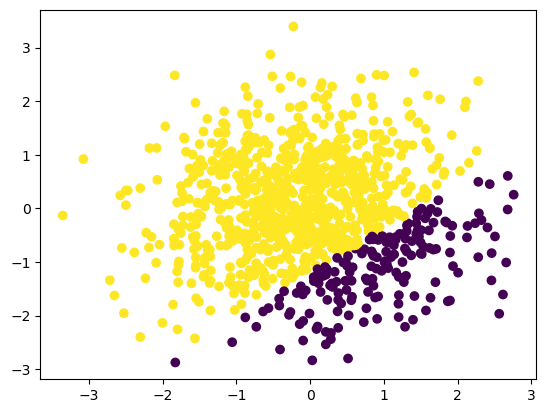

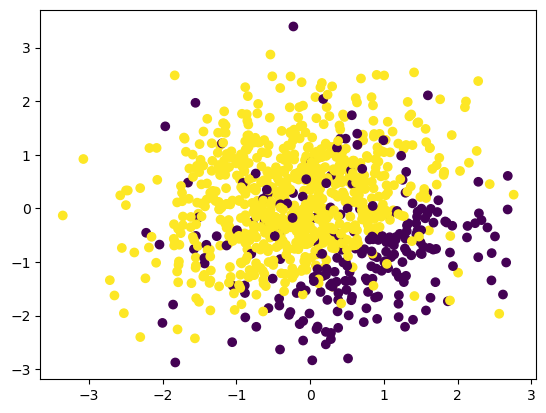

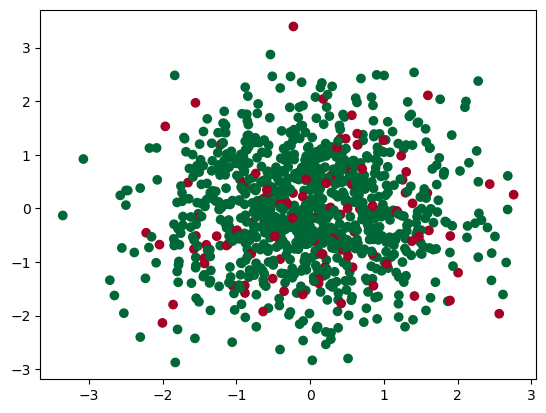

In [238]:
S_corr = make_corrupted_dataset(alpha=0.1)
Y_corr = S_corr.tensors[1]

plt.figure(1)
plt.scatter(X1, X2, c=y)
plt.figure(2)
plt.scatter(X1, X2, c=Y_corr)
plt.figure(3)
plt.scatter(X1,X2, c=(y==Y_corr), cmap='RdYlGn',)

### Entraînement sur les données corrompues

In [239]:
train_loader_corrupted, _ = train_test_split(S_corr)

model1 = LogisticRegressionModel(input_dim=2)  # 2 caractéristiques

# On évalue le modèle corrompu sur les données NON corrompues
train_model(model1, train_loader_corrupted, val_loader, verbose=True)

Epoch 10/100, Loss: 0.6478, Val Loss: 0.5508
Epoch 20/100, Loss: 0.4820, Val Loss: 0.4701
Epoch 30/100, Loss: 0.4965, Val Loss: 0.4180
Epoch 40/100, Loss: 0.3995, Val Loss: 0.3826
Epoch 50/100, Loss: 0.4106, Val Loss: 0.3570
Epoch 60/100, Loss: 0.4683, Val Loss: 0.3375
Epoch 70/100, Loss: 0.3333, Val Loss: 0.3224
Epoch 80/100, Loss: 0.3989, Val Loss: 0.3103
Epoch 90/100, Loss: 0.4787, Val Loss: 0.3005
Epoch 100/100, Loss: 0.4727, Val Loss: 0.2920


##### Fonction de précision

In [240]:
def accuracy(model, dataloader):
    model.eval()  # Met le modèle en mode évaluation
    correct = 0
    total = 0

    with torch.no_grad():  # Pas de calcul de gradient
        for inputs, labels in dataloader:
            outputs = model(inputs).squeeze()  # Prédictions du modèle
            # Appliquer un seuil de 0.5 pour la classification binaire
            predicted = (outputs > 0.5).float()  # Sortie 0 ou 1 selon le seuil
            total += len(labels)  # Nombre total d'exemples
            correct += (predicted == labels).sum().item()  # Nombre de prédictions correctes

    accuracy = correct / total  # Précision
    return accuracy

## Précision des différents modèles sur S_test

In [259]:
print(accuracy(model, val_loader))
print(accuracy(model1, val_loader))

0.975
0.975


# Variation de alpha

## Précision en fonction du pourcentage de corruption

In [263]:
acc = []
nb_points_alpha=30
for alpha_ in np.linspace(0, 1, nb_points_alpha):
    # Nouveau jeu de données corrompu
    S_c = make_corrupted_dataset(alpha_)
    train_loader_corr = DataLoader(S_c,batch_size=batch_size)
    # Création d'un nouveau modèle non entraîné
    model_a = LogisticRegressionModel(input_dim=2)
    # Entraînement du modèle
    train_model(model_a, train_loader_corr, val_loader)
    # Calcul de la précision
    acc.append(accuracy(model_a, val_loader))




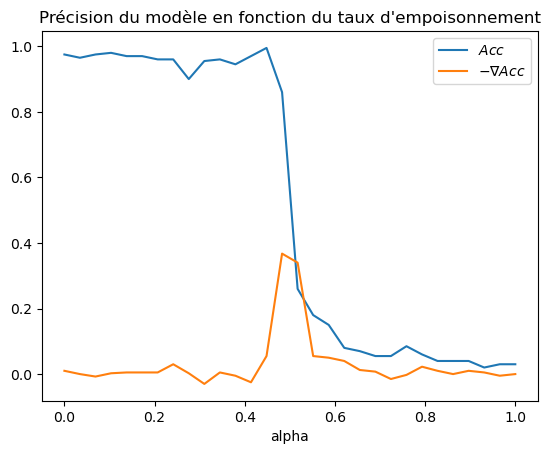

In [264]:

plt.plot(np.linspace(0, 1, nb_points_alpha), acc,label= '$Acc$')
plt.plot(np.linspace(0, 1, nb_points_alpha), -np.gradient(acc),label=r'$-\nabla Acc$')
plt.title("Précision du modèle en fonction du taux d'empoisonnement")
plt.xlabel('alpha')
plt.legend()


# Jeu de données avec clusters

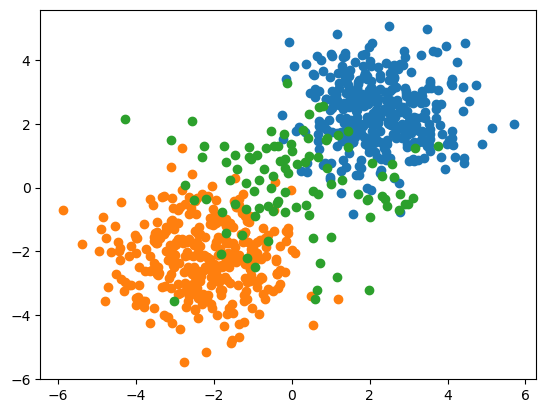

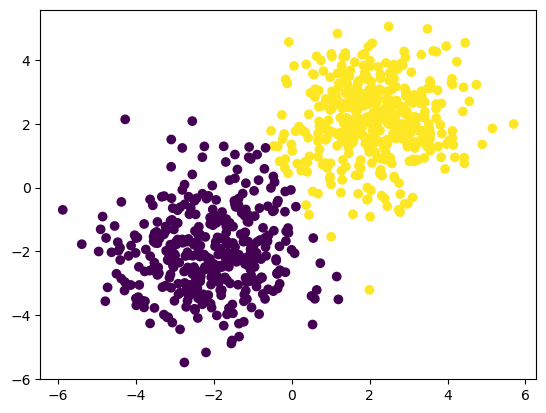

In [305]:
C1X = torch.normal(2.3,1.1,size=(350,2))
C1X1 = C1X[:, 0]
C1X2 = C1X[:, 1]

C2X = torch.normal(-2.3,1.1,size=(350,2))
C2X1 = C2X[:, 0]
C2X2 = C2X[:, 1]

RN = torch.normal(0,1.5,size=(100, 2))


plt.scatter(C1X1,C1X2)
plt.scatter(C2X1,C2X2)
plt.scatter(RN[:,0],RN[:,1])

SX = torch.cat((C1X1,C2X1,RN[:,0]))
SY = torch.cat((C1X2,C2X2,RN[:,1]))

Z = -2.3 * SX
yc = (SY > Z).int().float()

plt.figure()
plt.scatter(SX,SY,c=yc)

Sc = TensorDataset(torch.cat((C1X,C2X,RN)),yc)

## Corrompre au niveau de la frontière

In [306]:
## fonction de distance à la frontière

def dist(p,D):
    d = (D[0]*p[0]+D[1]*p[1]+D[2])/np.sqrt(D[0]**2 + D[1]**2)
    return d


## fonction des points voisins

def neigh_points (S,D,d):
    
    N = []
    for i in range (len(S[:][0])):
        if dist(S[i][0],D) < d and dist(S[i][0],D) > 0 :
            N.append(i)

    return torch.tensor(N)

def clone_tensor_dataset(dataset):
    cloned_tensors = tuple(tensor.clone() for tensor in dataset.tensors)
    return TensorDataset(*cloned_tensors)


## Corruption des données

def bord_corr (S,D,d,alpha):
    N = neigh_points(S,D,d)
    num_labels_to_flip = int(alpha*len(N))
    alpha_reel= num_labels_to_flip/len(S)
    # Sélectionner aléatoirement les indices à inverser
    flip_indices = np.random.choice(len(N), num_labels_to_flip, replace=False)

    Y = S[:][1].clone()

    ##changement des indices
    for i in flip_indices:
        
        j = N[i]
        Y[j] = 1- Y[j]
    
    return (TensorDataset(S[:][0].clone(),Y),alpha_reel)
    


In [322]:
%matplotlib inline

Le alpha réel correspondant est : 0.1075


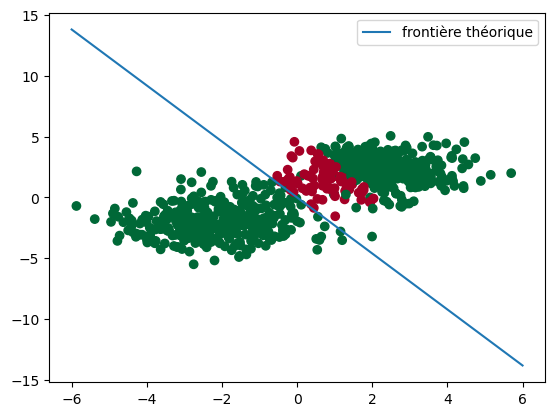

In [367]:
D=(2.3,1,0)
Sc_corr,alpha_reel = bord_corr(Sc,D,2,0.9)
print("Le alpha réel correspondant est :",alpha_reel)
Sc_corr_X = Sc_corr[:][0]
Sc_corr_X1 = Sc_corr_X[:,0]
Sc_corr_X2 = Sc_corr_X[:,1]

x_d=np.linspace(-6,6)
y_d=(-D[0]*x_d)/D[1]
plt.plot(x_d,y_d,label="frontière théorique")
plt.scatter(Sc_corr_X1,Sc_corr_X2,c = (Sc_corr[:][1]==Sc[:][1]),cmap='RdYlGn')
plt.legend()

In [316]:
model_cl = LogisticRegressionModel(input_dim=2)
train_loader, val_loader = train_test_split(Sc)
train_model(model_cl, train_loader, val_loader, verbose=True)
print(accuracy(model_cl,val_loader))




Epoch 10/100, Loss: 0.2134, Val Loss: 0.2138
Epoch 20/100, Loss: 0.1200, Val Loss: 0.1232
Epoch 30/100, Loss: 0.0739, Val Loss: 0.0939
Epoch 40/100, Loss: 0.0600, Val Loss: 0.0791
Epoch 50/100, Loss: 0.0567, Val Loss: 0.0699
Epoch 60/100, Loss: 0.0558, Val Loss: 0.0635
Epoch 70/100, Loss: 0.0513, Val Loss: 0.0589
Epoch 80/100, Loss: 0.0483, Val Loss: 0.0553
Epoch 90/100, Loss: 0.0490, Val Loss: 0.0523
Epoch 100/100, Loss: 0.0503, Val Loss: 0.0499
0.99375


In [318]:
acc = []
alphas_reels=[]
nb_points_alpha=20

for alpha_ in np.linspace(0, 1, nb_points_alpha):
    # Nouveau jeu de données corrompu
    Sc_corr,alpha_reel = bord_corr(Sc,D,2,alpha_)
    train_loader_corr = DataLoader(S_c,batch_size=batch_size)
    # Création d'un nouveau modèle non entraîné
    model_cl_c = LogisticRegressionModel(input_dim=2)
    # Entraînement du modèle
    train_model(model_cl_c,train_loader_c,val_loader_c)
    print(accuracy(model_cl_c,val_loader_c))
    alphas_reels.append(alpha_reel)
    acc.append(accuracy(model_cl_c, val_loader_c))

0.91875
0.9125
0.9125
0.91875
0.9125
0.9125
0.9125
0.9125
0.9125
0.9125
0.9125
0.9125
0.9125
0.9125
0.9125
0.91875
0.9125
0.91875
0.9125
0.91875


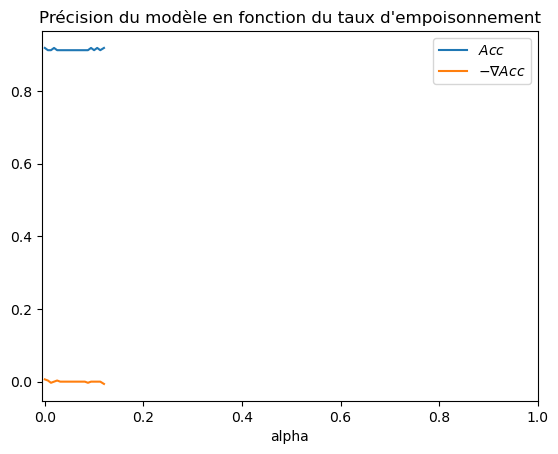

In [319]:
plt.plot(alphas_reels, acc,label= '$Acc$')
plt.plot(alphas_reels, -np.gradient(acc),label=r'$-\nabla Acc$')
plt.xlim(right=1)
plt.title("Précision du modèle en fonction du taux d'empoisonnement")
plt.xlabel('alpha')
plt.legend()

## FRONTIERE DE DECISION 

Cas d'un modèle non empoisonné : 

In [479]:
def plot_decision_boundary(model,X,y):
    plt.figure()
    """
    Affiche la frontière de décision pour un modèle de classification binaire en utilisant un DataLoader.
    """
    # Transformer en numpy pour l'affichage
    X_np = X.numpy()
    y_np = y.numpy()

    # Définir les limites de la grille
    x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
    y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), 
                         np.linspace(y_min, y_max, 100))
    
    # Transformer en tensor PyTorch et faire des prédictions
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        preds = model(grid).squeeze().numpy()  # Probabilités

    # Transformer en 0/1 (seuil à 0.5)
    preds = preds.reshape(xx.shape)
    
    # Afficher la frontière avec contourf
    plt.contourf(xx, yy, preds, levels=[0, 0.5, 1], alpha=0.6, cmap="coolwarm")
    
    # Tracer les points de l'ensemble de données
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap="coolwarm", edgecolors="k")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Frontière de décision, sans corruption")
    plt.show()

# Exemple d'utilisation :
# data_loader : ton DataLoader PyTorch contenant (X, y)
# model : ton modèle entraîné


In [480]:
def plot_decision_boundary_corrupted(model,X,y_corrupted,y_pur):
    """
    Affiche la frontière de décision pour un modèle de classification binaire en utilisant un DataLoader.
    """
    plt.figure()
    # Transformer en numpy pour l'affichage
    X_np = X.numpy()
    y_np = y_corrupted.numpy()
    y_pur_np=y_pur.numpy()

    # Définir les limites de la grille
    x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
    y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), 
                         np.linspace(y_min, y_max, 100))
    
    # Transformer en tensor PyTorch et faire des prédictions
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        preds = model(grid).squeeze().numpy()  # Probabilités

    # Transformer en 0/1 (seuil à 0.5)
    preds = preds.reshape(xx.shape)
    
    # Afficher la frontière avec contourf
    plt.contourf(xx, yy, preds, levels=[0, 0.5, 1], alpha=0.6, cmap="coolwarm")
    
    cmap = plt.get_cmap("coolwarm")
    y_np_color= cmap(y_np)
    # Tracer les points de l'ensemble de données
    for i in range(len(X_np)):
        if y_np[i]==y_pur_np[i] : #point non corrompu 
            if y_np[i]==1 : 
                plt.scatter(X_np[i, 0], X_np[i, 1], s=25, c=y_np_color[i], edgecolors="k",label="données non corrompues, label 1")
            else :
                plt.scatter(X_np[i, 0], X_np[i, 1],s=25, c=y_np_color[i], edgecolors="k", label="données non corrompues, label 0")
        if y_np[i]!=y_pur_np[i] : #point corrompu 
            if y_np[i]==1 : 
                plt.scatter(X_np[i, 0], X_np[i, 1], s=50, c=y_np_color[i],  marker='^',edgecolors="k",label="données corrompues, label 1")
            else : 
                plt.scatter(X_np[i, 0], X_np[i, 1], s =75, c=y_np_color[i], marker='^',edgecolors="k",label="données corrompues, label 0")
    plt.xlabel("x")
    plt.ylabel("y")
    # Suppression des doublons dans la légende
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Crée un dictionnaire unique {label: handle}
    plt.legend(by_label.values(), by_label.keys())
    
    plt.title("Frontière de décision, corruption à la frontière")
    plt.show()


In [467]:
model = LogisticRegressionModel(input_dim=2)
model_corrupted = LogisticRegressionModel(input_dim=2)
train_loader, val_loader = train_test_split(Sc)

X=Sc[:][0]
y=Sc[:][1]


#Deuxième jeu de données corrompus :
Sc_corr,alpha_reel = bord_corr(Sc,D,2,0.7)
train_loader_corrupted=DataLoader(Sc_corr,batch_size=batch_size)
y_corrupted=Sc_corr[:][1]

train_model(model, train_loader, val_loader, verbose=True)
train_model(model_corrupted, train_loader_corrupted, val_loader, verbose=True)
print("Accuracy du modèle non corrompu :",accuracy(model,val_loader))
print("Accuracy du modèle corrompu :",accuracy(model_corrupted,val_loader))
print("Taux de corruption du modèle",alpha_reel)

Epoch 10/100, Loss: 0.0800, Val Loss: 0.0821
Epoch 20/100, Loss: 0.0276, Val Loss: 0.0533
Epoch 30/100, Loss: 0.0398, Val Loss: 0.0418
Epoch 40/100, Loss: 0.0349, Val Loss: 0.0354
Epoch 50/100, Loss: 0.0086, Val Loss: 0.0311
Epoch 60/100, Loss: 0.0322, Val Loss: 0.0280
Epoch 70/100, Loss: 0.0196, Val Loss: 0.0256
Epoch 80/100, Loss: 0.0108, Val Loss: 0.0237
Epoch 90/100, Loss: 0.0264, Val Loss: 0.0222
Epoch 100/100, Loss: 0.0270, Val Loss: 0.0209
Epoch 10/100, Loss: 0.6366, Val Loss: 0.0977
Epoch 20/100, Loss: 0.5431, Val Loss: 0.0834
Epoch 30/100, Loss: 0.4848, Val Loss: 0.0813
Epoch 40/100, Loss: 0.4489, Val Loss: 0.0811
Epoch 50/100, Loss: 0.4255, Val Loss: 0.0813
Epoch 60/100, Loss: 0.4090, Val Loss: 0.0817
Epoch 70/100, Loss: 0.3968, Val Loss: 0.0822
Epoch 80/100, Loss: 0.3873, Val Loss: 0.0827
Epoch 90/100, Loss: 0.3798, Val Loss: 0.0833
Epoch 100/100, Loss: 0.3736, Val Loss: 0.0839
Accuracy du modèle non corrompu : 1.0
Accuracy du modèle corrompu : 0.96875
Taux de corruption du 

In [476]:

plot_decision_boundary(model,X,y)


In [481]:
plot_decision_boundary_corrupted(model_corrupted,X,y_corrupted,y)

C:\Users\poule\AppData\Local\Temp\ipykernel_21100\1375094750.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_np[i, 0], X_np[i, 1], s=25, c=y_np_color[i], edgecolors="k",label="données non corrompues, label 1")
C:\Users\poule\AppData\Local\Temp\ipykernel_21100\1375094750.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_np[i, 0], X_np[i, 1], s =75, c=y_np_color[i], marker='^',edgecolors="k"

In [473]:
%matplotlib tk